# Thorough Gridsearch Model


This notebook contains code to easily add a model and preprocessor(s) and gridsearch through every possible combination to find the best

## Future:
Compare bagging, boosting, gradient, with base model.

---

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from pprint import pprint
from xgboost import XGBClassifier

%load_ext autoreload
%autoreload 2

In [2]:
from util import databases
from util import dataloader
from util import grid_models
from util.reddit_functions import Labeler
from util.reddit_functions import plot_confusion_matrix
from util.grid_models import custom_stop_words, get_random_class_labels

In [3]:
labels = get_random_class_labels(8)
print(labels)

df = dataloader.data_selector(labels, data_source='sqlite')

df.sample(10)

['aws' 'awscertifications' 'css' 'shittyprogramming' 'apachespark'
 'learnsql' 'datascience' 'machinelearning']
Connection to SQLite DB successful


,title,subreddit,date
3373,Just a Haskell question.,shittyprogramming,2020-03-29
39999,Layering opaque gradient doesn't work?,css,2020-04-21
68422,Architecture deep-dive: How a news aggregator ...,aws,2020-04-25
98851,Cloudformation: Can I use !Sub and !ImportValu...,aws,2020-04-30
2177,Is there a difference between setting a flex v...,css,2020-03-29
953,"If I exit my lambda early, am I saving money?",aws,2020-03-29
126638,AD Connector with third party vpn?,aws,2020-05-09
32425,Realistic looking on/off toggle using only CSS...,css,2020-04-20
5193,Why does the number of Tasks in each stage kee...,apachespark,2020-03-29
82658,[P] College Admissions Dataset,machinelearning,2020-04-27


In [4]:
X = df['title']
y = df['subreddit']

In [5]:
### TODO ### use scikit-learn labeler

In [6]:
labeler = Labeler()
labeler.fit(y)
y = labeler.transform(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [8]:
tfidf = {
    'preprocessor': TfidfVectorizer(stop_words=custom_stop_words),
    'params': {
        "prep__ngram_range": [(1, 2)],
        "prep__max_df": [.9],
        "prep__use_idf": [True],
        "prep__norm": ["l2"]
    }
}

In [9]:
lr = {
    'clf': LogisticRegression(max_iter=1000),
    'params': {
        "clf__C": [.01, .1, 1, 5]
    }
    
}

In [10]:
xgb = {
    'clf': XGBClassifier(n_jobs=-1),
    'params': {
        "clf__max_depth": [3, 5, 10, 20, 50],
        "clf__learning_rate": np.linspace(.001, .99, 5),
        "clf__n_estimators": [50, 100, 200],
        "clf__objective": ['binary:logistic', 'multi:softprob'],
        "clf__booster": ['gbtree', 'gblinear', 'dart'],
        "clf__gamma": np.linspace(0, 1, 5),
        "clf__subsample": np.linspace(.5, 1, 5),
        "clf__reg_alpha": np.linspace(0, 1, 5),
        "clf__reg_lambda": np.linspace(0, 1, 5),
        "clf__importance_type": ['gain', 'weight', 'cover', 'total_gain', 'total_cover'],
        "clf__hidden_layer_sizes": [10, 20, 30, 40, 50],
    }
}

In [11]:
random = {
    'clf': RandomForestClassifier(),
    'params': {
        "clf__n_estimators": [200, 300]
    }
}

In [12]:
onevrest = {
    'clf': OneVsRestClassifier(RandomForestClassifier()),
    'params': {
        "clf__estimator__n_estimators": [200, 300]
    }
}

In [13]:
def build_and_train_model(preprocessor, classifier, cv=3, verbose=1):
    '''
    Takes a dictionary with params and outputs a fitted model
    '''
    pipe = Pipeline(
    [('prep', preprocessor.get('preprocessor')),
     ('clf', classifier.get('clf'))])
    
    pipe_params = dict()
    pipe_params.update(preprocessor.get('params'))
    pipe_params.update(classifier.get('params'))
    
    model = GridSearchCV(pipe, param_grid=pipe_params, cv=cv, verbose=verbose, n_jobs=-1)
    model.fit(X_train, y_train)
    return model

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    6.7s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   11.6s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   15.4s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   15.9s finished


Train Score: 0.989660426643448
Test Score: 0.7215148547175971
AUC Score: 0.9285424291439139
              precision    recall  f1-score   support

           0      0.714     0.867     0.783       707
           1      0.870     0.846     0.858       363
           2      0.828     0.796     0.811       362
           3      0.640     0.483     0.551       269
           4      0.679     0.660     0.669       285
           5      0.723     0.462     0.564       249
           6      0.509     0.476     0.492       288
           7      0.726     0.800     0.761       540

    accuracy                          0.722      3063
   macro avg      0.711     0.674     0.686      3063
weighted avg      0.720     0.722     0.715      3063



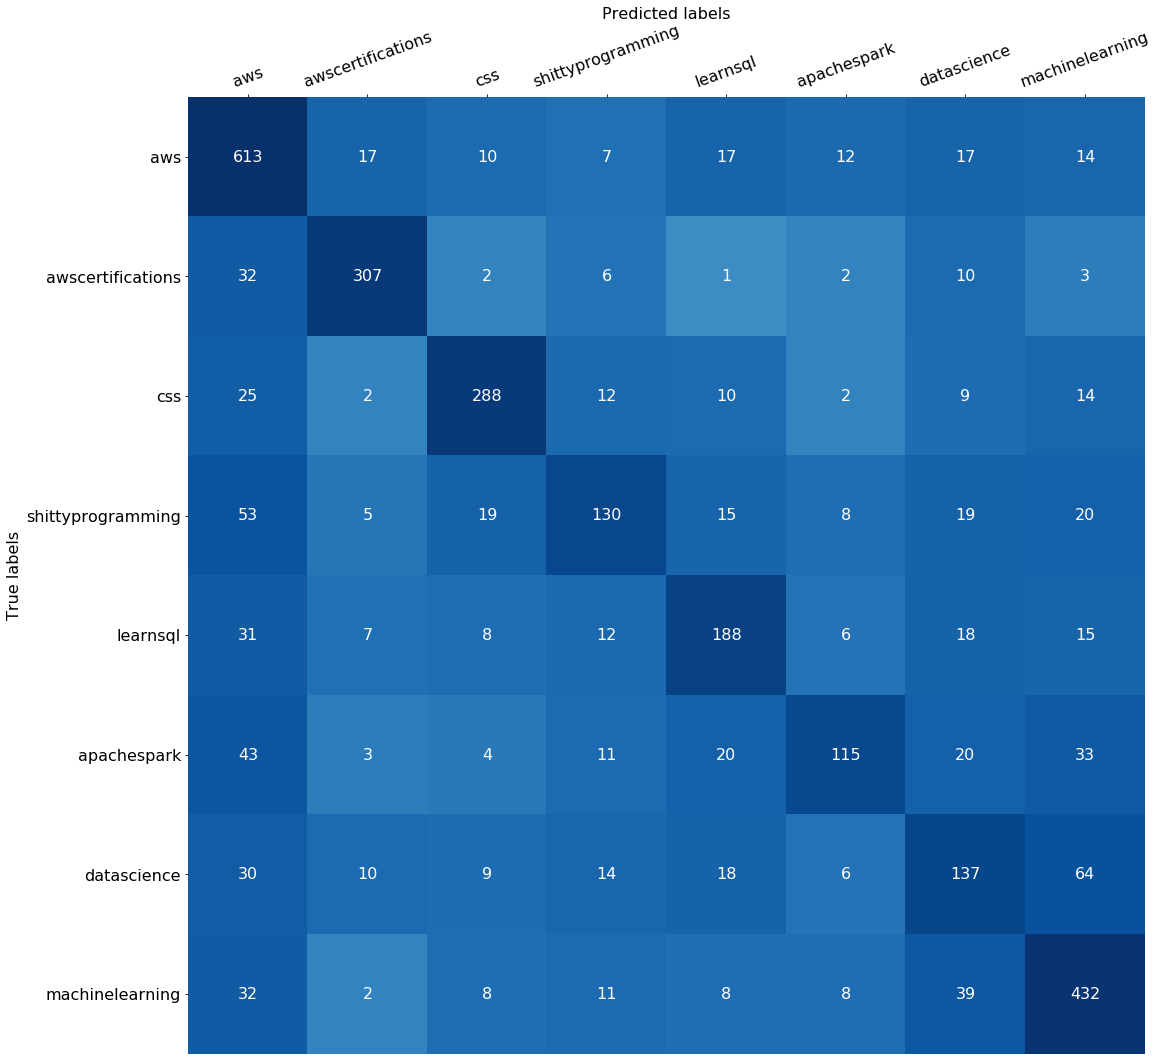

In [15]:
for estimator in [xgb]:
    
    model = build_and_train_model(preprocessor=tfidf, classifier=estimator, verbose=5)
    
    print(f'Train Score: {model.score(X_train, y_train)}')
    print(f'Test Score: {model.score(X_test, y_test)}')
    
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
        print(f'AUC Score: {roc_auc_score(y_test, y_proba, multi_class="ovr")}')
        
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))

    plot_confusion_matrix(model, y_test, y_pred, classes=labeler.classes_)
    plt.show()

In [17]:
import joblib

# Save to file in the current working directory
joblib_file = "best_model.pkl"
joblib.dump(model, joblib_file)

['best_model.pkl']